Implement the Miller-Tucker-Zemlin model for the TSP.
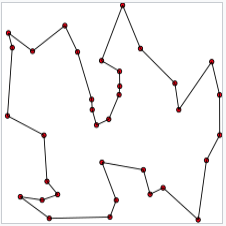

In [1]:
import networkx as nx

n = 20                                   # number of cities
G = nx.complete_graph(n, nx.DiGraph())  # *directed* graph with a vertex for each city

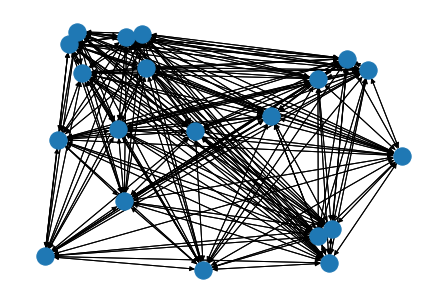

In [2]:
# for convenience, pick the city (x,y)-coordinates at random
import random

my_pos = { i : ( random.random(), random.random() ) for i in G.nodes } # pos[i] = (x_i, y_i)
nx.draw(G, pos=my_pos)

In [3]:
# for convenience, suppose that distances are Euclidean
import math
def eucl_dist(x1,y1,x2,y2):
    return math.sqrt( (x1-x2)**2 + (y1-y2)**2 )

for i,j in G.edges:
    (x1,y1) = my_pos[i]
    (x2,y2) = my_pos[j]
    G.edges[i,j]['length'] = eucl_dist(x1,y1,x2,y2)

In [4]:
import gurobipy as gp
from gurobipy import GRB

In [5]:
# First, solve the assignment relaxation

m = gp.Model()
x = m.addVars(G.edges,vtype=GRB.BINARY)

m.setObjective( gp.quicksum( G.edges[i,j]['length'] * x[i,j] for i,j in G.edges ), GRB.MINIMIZE )

# Enter each city once
m.addConstrs( gp.quicksum( x[i,j] for i in G.predecessors(j) ) == 1 for j in G.nodes )

# Leave each city once
m.addConstrs( gp.quicksum( x[i,j] for j in G.successors(i) ) == 1 for i in G.nodes )

m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40 rows, 380 columns and 760 nonzeros
Model fingerprint: 0xd347e2af
Variable types: 0 continuous, 380 integer (380 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 11.7140214
Presolve time: 0.00s
Presolved: 40 rows, 380 columns, 760 nonzeros
Variable types: 0 continuous, 380 integer (380 binary)

Root relaxation: objective 3.679637e+00, 40 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       3.6796372    3.67964  0.00%  

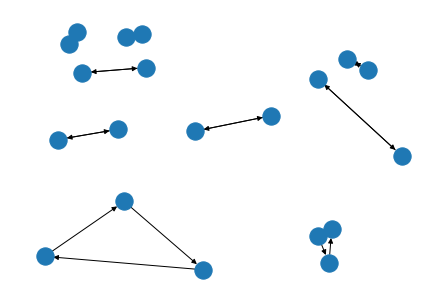

In [6]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)

In [7]:
# Add the original Miller-Tucker-Zemlin variables and constraints
u = m.addVars( G.nodes )
c = m.addConstrs( u[i] - u[j] + n * x[i,j] <= n - 1 for i,j in G.edges if j != 0 )
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 401 rows, 400 columns and 1843 nonzeros
Model fingerprint: 0x2ecd1fb0
Variable types: 20 continuous, 380 integer (380 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [5e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 401 rows, 399 columns, 1824 nonzeros
Variable types: 19 continuous, 380 integer (380 binary)
Found heuristic solution: objective 4.8154369

Root relaxation: objective 3.703798e+00, 78 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.70380    0   36    4.

In [8]:
# Try again, using stronger ("lifted") version of these constraints

m.remove(c)  # remove the previous MTZ constraints
m.addConstrs( u[i] - u[j] + (n-1) * x[i,j] + (n-3) * x[j,i] <= n-2 for i,j in G.edges if j != 0 )

m.reset()    # start solve process from scratch
m.optimize()

Discarded solution information
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 401 rows, 400 columns and 2204 nonzeros
Model fingerprint: 0x6bf4ee2d
Variable types: 20 continuous, 380 integer (380 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [5e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 401 rows, 399 columns, 2185 nonzeros
Variable types: 19 continuous, 380 integer (380 binary)

Root relaxation: objective 3.946905e+00, 79 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.94691    0   34          -    3.94691      -     -    0s
H    0     0                      11.9980034    3.94

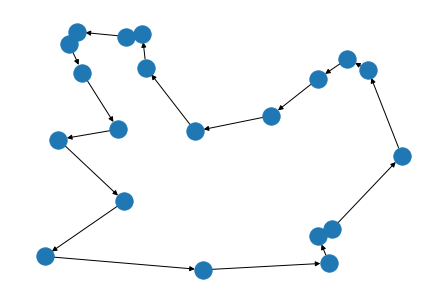

In [9]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)